In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
project_name = "bird-classification-cnn"

In [ ]:
import os
from random import randrange
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.models as models
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/kaggle_dataset/100-bird-species'
species = os.listdir(data_dir + "/train")
num_classes = len(species)
print("num species:", num_classes)
print({cls: len(os.listdir(data_dir + f"/train/{cls}/")) for cls in sorted(species)})

num species: 174
{'AFRICAN CROWNED CRANE': 137, 'AFRICAN FIREFINCH': 140, 'ALBATROSS': 133, 'ALEXANDRINE PARAKEET': 165, 'AMERICAN AVOCET': 179, 'AMERICAN BITTERN': 170, 'AMERICAN COOT': 158, 'AMERICAN GOLDFINCH': 133, 'AMERICAN KESTREL': 130, 'AMERICAN PIPIT': 179, 'AMERICAN REDSTART': 139, 'ANHINGA': 147, 'ANNAS HUMMINGBIRD': 139, 'ANTBIRD': 150, 'ARARIPE MANAKIN': 105, 'ASIAN CRESTED IBIS': 105, 'BALD EAGLE': 160, 'BALI STARLING': 132, 'BALTIMORE ORIOLE': 137, 'BANANAQUIT': 106, 'BANDED BROADBILL': 194, 'BAR-TAILED GODWIT': 114, 'BARN OWL': 119, 'BARN SWALLOW': 132, 'BARRED PUFFBIRD': 136, 'BAY-BREASTED WARBLER': 143, 'BEARDED BARBET': 160, 'BELTED KINGFISHER': 125, 'BIRD OF PARADISE': 104, 'BLACK FRANCOLIN': 131, 'BLACK SKIMMER': 111, 'BLACK SWAN': 112, 'BLACK TAIL CRAKE': 149, 'BLACK THROATED WARBLER': 135, 'BLACK VULTURE': 126, 'BLACK-CAPPED CHICKADEE': 133, 'BLACK-NECKED GREBE': 105, 'BLACK-THROATED SPARROW': 168, 'BLACKBURNIAM WARBLER': 134, 'BLUE GROUSE': 185, 'BLUE HERON': 10

In [ ]:
transform = tt.Compose(
    [
        tt.ToTensor(),
    ]
)

train_ds = ImageFolder(data_dir+'/train', transform)
valid_ds = ImageFolder(data_dir+'/test', transform)

batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

classes = valid_ds.classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


BROWN NOODY


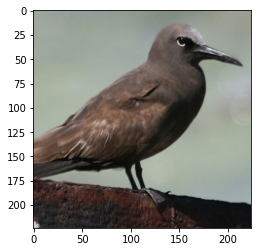

In [ ]:
def show_example(data):
    [img, label] = data
    print(classes[label])
    plt.imshow(img.permute(1, 2, 0))


image_number = randrange(20000)
show_example(train_ds[image_number])

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


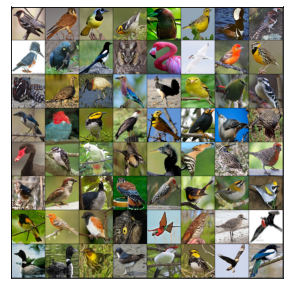

In [ ]:
show_batch(train_dl)

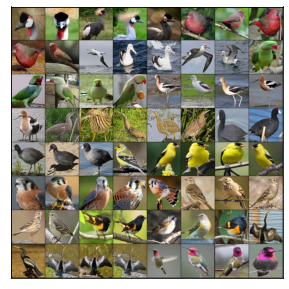

In [ ]:
show_batch(valid_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = get_default_device()
device

device(type='cpu')

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class BirdResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True

    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
model = to_device(BirdResnet(), device)
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


BirdResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
torch.cuda.empty_cache()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
to_device(model, device)

# print outputs for a single batch
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('all outputs:', out)
    break

# show the highest probability values and their index/classes
values, indices = out.max(0)
print("max values", values)
print("max indices", indices)
print("guesses", [classes[index] for index in indices])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([64, 3, 224, 224])
out.shape: torch.Size([64, 174])
all outputs: tensor([[0.2324, 0.5959, 0.4201,  ..., 0.5769, 0.6552, 0.4242],
        [0.3921, 0.6887, 0.3863,  ..., 0.5519, 0.6750, 0.4070],
        [0.2932, 0.5699, 0.5018,  ..., 0.2870, 0.6974, 0.3017],
        ...,
        [0.3754, 0.6250, 0.4802,  ..., 0.5270, 0.6659, 0.5004],
        [0.2940, 0.8131, 0.3553,  ..., 0.6586, 0.8659, 0.3722],
        [0.3905, 0.6347, 0.4235,  ..., 0.5045, 0.7238, 0.4312]],
       grad_fn=<SigmoidBackward>)
max values tensor([0.5180, 0.8131, 0.6960, 0.5988, 0.6703, 0.8446, 0.5601, 0.7172, 0.6746,
        0.6330, 0.7865, 0.6000, 0.5245, 0.6855, 0.4374, 0.8769, 0.5952, 0.8136,
        0.6876, 0.8819, 0.5649, 0.7259, 0.8031, 0.6880, 0.7196, 0.6674, 0.8227,
        0.8961, 0.7957, 0.7728, 0.7751, 0.8366, 0.7312, 0.6633, 0.4702, 0.7451,
        0.8441, 0.5809, 0.7257, 0.8383, 0.7795, 0.6836, 0.8746, 0.7245, 0.6767,
        0.7607, 0.8467, 0.7786, 0.7791, 0.6382, 0.7858, 0.7950, 0.7

In [ ]:
# create the test dataset
test_dataset = ImageFolder(data_dir+'/test', tt.ToTensor())

#methods to pick a random image and make a prediciton
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

def get_random_test_image(dataset):
    rand_num = randrange(len(dataset))
    return dataset[rand_num]

Label: TRUMPTER SWAN , Predicted: HIMALAYAN MONAL


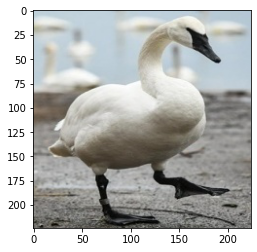

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: WATTLED CURASSOW , Predicted: HIMALAYAN MONAL


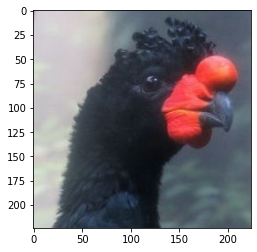

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: OYSTER CATCHER , Predicted: HIMALAYAN MONAL


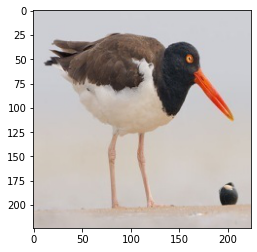

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

IndexError: ignored

In [ ]:
# freeze the model to only train the last layer
model.freeze()


In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.


In [ ]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

Epoch [0], train_loss: 4.6208, val_loss: 4.4590, val_acc: 0.4419
Epoch [1], train_loss: 4.4502, val_loss: 4.4725, val_acc: 0.4245
Epoch [2], train_loss: 4.4137, val_loss: 4.4025, val_acc: 0.6001
Epoch [3], train_loss: 4.3948, val_loss: 4.3751, val_acc: 0.6980
Epoch [4], train_loss: 4.3860, val_loss: 4.3724, val_acc: 0.6541
Epoch [5], train_loss: 4.3722, val_loss: 4.3566, val_acc: 0.7482
Epoch [6], train_loss: 4.3673, val_loss: 4.3589, val_acc: 0.7323
Epoch [7], train_loss: 4.3624, val_loss: 4.3584, val_acc: 0.7411
Epoch [8], train_loss: 4.3573, val_loss: 4.3751, val_acc: 0.7015
Epoch [9], train_loss: 4.3554, val_loss: 4.3704, val_acc: 0.7123


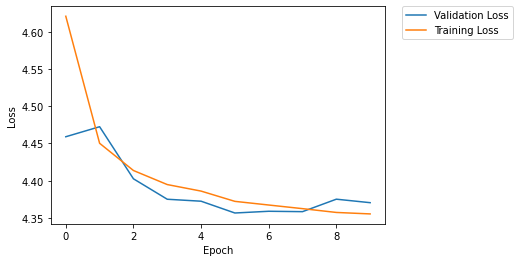

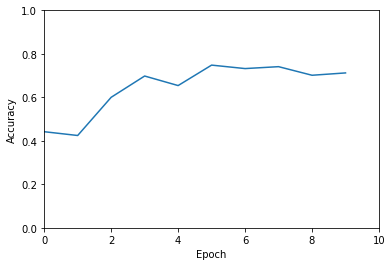

In [ ]:
val_loss = [hist['val_loss'] for hist in history]
train_loss = [hist['train_loss'] for hist in history]
val_acc = [hist['val_acc'] for hist in history]
plt.plot(val_loss, label="Validation Loss")
plt.plot(train_loss, label="Training Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

plt.plot()
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axis([0, 10, 0, 1])
plt.show()

In [ ]:
# test_dataset = ImageFolder(data_dir+'/test', tt.ToTensor())
# print(len(test_dataset))

NameError: name 'ImageFolder' is not defined

In [ ]:
# def predict_image(img, model):
#     # Convert to a batch of 1
#     xb = to_device(img.unsqueeze(0), device)
#     # Get predictions from model
#     yb = model(xb)
#     # Pick index with highest probability
#     _, preds  = torch.max(yb, dim=1)
#     # Retrieve the class label
#     return test_dataset.classes[preds[0].item()]

In [ ]:
# def get_random_test_image(dataset):
#     rand_num = randrange(len(dataset))
#     return dataset[rand_num]

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: COMMON GRACKLE , Predicted: COMMON GRACKLE


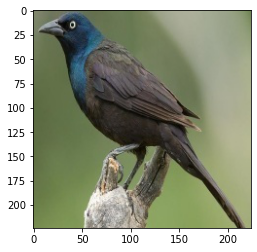

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: CANARY , Predicted: CANARY


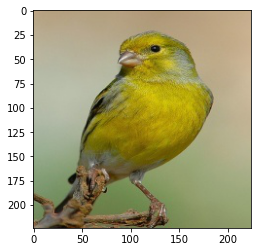

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: BLACK VULTURE , Predicted: WHITE NECKED RAVEN


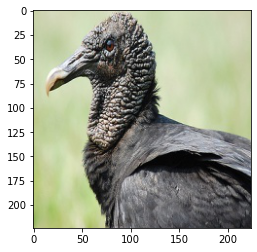

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: MYNA , Predicted: MYNA


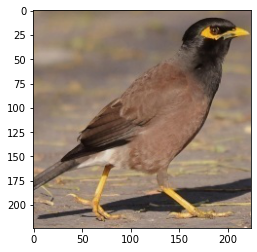

In [ ]:
img, label = test_dataset[600]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

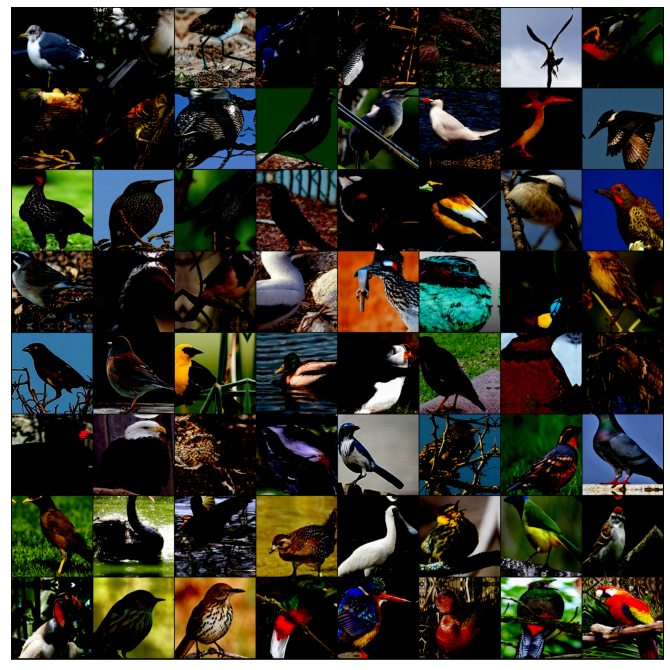

In [ ]:
# some data transforms and augmentation to improve accuracy

stats = ((0.5,0.5,0.5), (0.5,0.5,0.5))
train_transform = tt.Compose(
    [
        tt.RandomCrop(200, padding=20, padding_mode='reflect'),
        tt.RandomHorizontalFlip(),
        tt.ToTensor(),
        tt.Normalize(*stats),
    ]
)
valid_transform = tt.Compose(
    [
        tt.ToTensor(),
        tt.Normalize(*stats)
    ]
)

# Create datasets
train_ds = ImageFolder(data_dir+'/train', train_transform)
valid_ds = ImageFolder(data_dir+'/valid', valid_transform)
test_ds = ImageFolder(data_dir+'/test', valid_transform)

# set the batch size
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

classes = valid_ds.classes

show_batch(train_dl)

In [ ]:
# a slightly more advanced training loop for increased accuracy
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
class BirdResnet2(BirdResnet):
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
torch.cuda.empty_cache()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
model = to_device(BirdResnet2(), device)
model

BirdResnet2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
epochs = 15
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 5.321384429931641, 'val_acc': 0.00390625}]

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00015, train_loss: 4.7889, val_loss: 4.4391, val_acc: 0.8697
Epoch [1], last_lr: 0.00044, train_loss: 4.4372, val_loss: 4.4048, val_acc: 0.7195
Epoch [2], last_lr: 0.00076, train_loss: 4.4404, val_loss: 4.4752, val_acc: 0.5288
Epoch [3], last_lr: 0.00097, train_loss: 4.4495, val_loss: 4.4381, val_acc: 0.5522
Epoch [4], last_lr: 0.00099, train_loss: 4.4494, val_loss: 4.4529, val_acc: 0.5168
Epoch [5], last_lr: 0.00095, train_loss: 4.4355, val_loss: 4.4244, val_acc: 0.5990
Epoch [6], last_lr: 0.00087, train_loss: 4.4278, val_loss: 4.3933, val_acc: 0.7016
Epoch [7], last_lr: 0.00075, train_loss: 4.4165, val_loss: 4.3924, val_acc: 0.6989
Epoch [8], last_lr: 0.00061, train_loss: 4.4011, val_loss: 4.3752, val_acc: 0.7332
Epoch [9], last_lr: 0.00046, train_loss: 4.3891, val_loss: 4.3616, val_acc: 0.7840
Epoch [10], last_lr: 0.00032, train_loss: 4.3719, val_loss: 4.3493, val_acc: 0.8353
Epoch [11], last_lr: 0.00019, train_loss: 4.3567, val_loss: 4.3382, val_acc: 0.8561
Ep

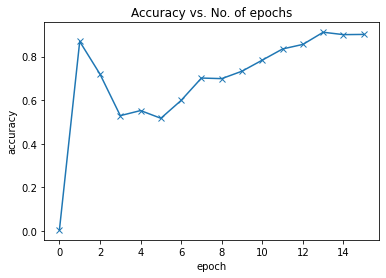

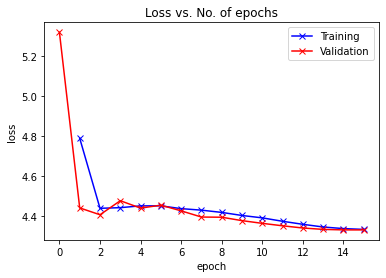

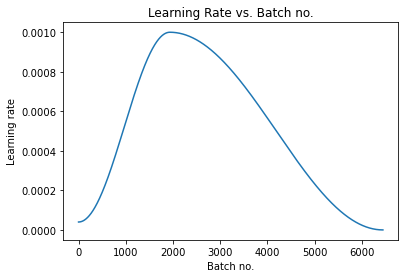

In [ ]:
# plot accuracy
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.show()

# plot losses
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

# plor learning rates
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.plot(lrs)
plt.xlabel('Batch no.')
plt.ylabel('Learning rate')
plt.title('Learning Rate vs. Batch no.')
plt.show()

In [ ]:
print(evaluate(model, valid_dl))

IndexError: ignored

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

NameError: name 'get_random_test_image' is not defined

Label: TRUMPTER SWAN , Predicted: TRUMPTER SWAN


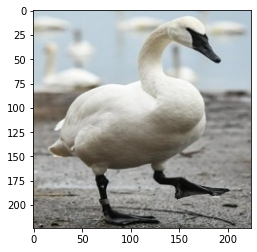

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: EURASIAN MAGPIE , Predicted: EURASIAN MAGPIE


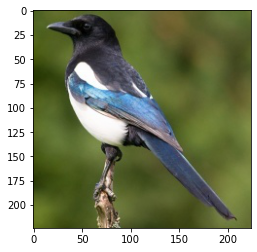

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: PUFFIN , Predicted: PUFFIN


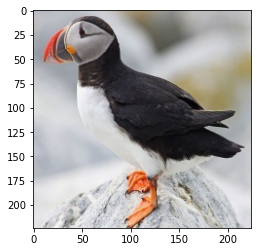

In [ ]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/jonschwa/bird-classification-cnn


<IPython.core.display.Javascript object>